In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'climate-change-earth-surface-temperature-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29%2F2150%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240217%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240217T052517Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6f6b931df621366177b7214efe22eaea0f265d6c137625049edce27ddeb7915ed264eab4c6b883ec9a332f1dcc4eb3844b6886e7ab659b2efe8647168a9264931fbd09ecad574fd38827c3a949c33323386d3da18428d98c080fb1876f4ce665351463e40d68ce7ac278868bdb60912e8ffa5ac1186e165085f0e3ed020b97f08cd4bfcf4753c8117f8c72ca79229b032eefe139b20d39d0e18ae5111a90a2ea69e64767e926a826f74c80b6862308243317591cecda1f2cc7b9026c6c094981702ad85eaf983b8eacb0ba85c7b90a6a4ebaa95aea4166d6c9b1b8d9c84466a07320ce765cca98289affeed67b2f05afe08152413cb1767f4b4c59be1aefb6b5,natural-disaster-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F166985%2F380029%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240217%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240217T052517Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D397884291f55294802152aeee97b922d87c2cd031ed77bb9dc77beb7adbb2ca305f455e7dbaeb1851cff36c4a4b056e95f3ea7ad67276dbbc62535e8f76ba9eba811edd534b2b9e736f29e4e5cc6809fc2ac0a6de196021b53e7ba98f9431b473f9f02b08361a8fb8814cc0eccfe5d3f6b2d2f0563736dee93843fc498875c80626dcb8eb7df62cc482adbd5ab926f09f9e501062da6876db434cbbc4307f9b784a8c443b43a43b0c00e7664ac53afb93aa980908c7d6181a407eeb894d43e40c12020e74eb399e87b6cd17571d8f3772e1b404dab031d1c01f176441da95d26c196969edef7ecdabf1e558eae4e87d751ace47250110f5f152a08a04c08cd0c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 88843537 bytes downloaded
Downloaded and uncompressed: climate-change-earth-surface-temperature-data
[==================================================] 7182 bytes downloaded
Downloaded and uncompressed: natural-disaster-data
Data source import complete.


# An exploratory data analysis of climate change and natural disasters

The objective is to explore and analyse climate change and its relation to natural disasters (occurrence and economic impact). For this analysis, global temperature rise is used as an indicator of climate change.<br><br>The source of the global temperature data is the Kaggle dataset https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data by Berkeley Earth.<br>Natural diasaster data is taken from https://ourworldindata.org/natural-disasters (data published by EMDAT (2019): OFDA/CRED International Disaster Database, Université catholique de Louvain – Brussels – Belgium)

In [2]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import style
style.use('seaborn')
%matplotlib inline

<ipython-input-2-4ed8ec2c7021>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


## Global temperature

In [3]:
# Load the global temperature dataset and store it in a dataframe
orig_temp_data = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv')
global_temp_df = orig_temp_data.copy()

global_temp_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


After observing the data, remove the data not required for the analysis and keep only the relevant data. The column 'LandAndOceanAverageTemperature' gives information about the overall earth temperature.<br><br>The global temperature dataset has monthly granularity. It can be resampled annually to reduce the number of entries, without losing the average temperature information.

In [4]:
# Choose the required columns
global_temp_df = global_temp_df[['dt', 'LandAndOceanAverageTemperature']]

# Set the date column as a DateTimeIndex and sort it
global_temp_df['dt'] = pd.to_datetime(global_temp_df['dt'])
global_temp_df.set_index('dt', inplace = True)
global_temp_df.sort_index(axis = 0, inplace = True)

# Resample annually and rename index & columns
global_temp_df = global_temp_df.resample('A').mean()
global_temp_df.rename(columns = {'LandAndOceanAverageTemperature': 'AnnualAverageTemp'}, inplace = True)
global_temp_df.index.rename('Year', inplace = True)
global_temp_df.index = global_temp_df.index.year

<ipython-input-4-fd3896b19be7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_temp_df['dt'] = pd.to_datetime(global_temp_df['dt'])


In [5]:
# Check the number of missing values and the corresponding years
print(global_temp_df.isnull().sum())
print(global_temp_df[global_temp_df['AnnualAverageTemp'].isnull()].index)

AnnualAverageTemp    100
dtype: int64
Int64Index([1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760,
            1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771,
            1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782,
            1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793,
            1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804,
            1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815,
            1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826,
            1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837,
            1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848,
            1849],
           dtype='int64', name='Year')


The first hundred years from 1750 don't have temperature values. Drop those entries to begin the analysis from 1850 onwards.

In [6]:
global_temp_df.dropna(inplace = True)

In climate science, temperature anomaly represents temperature pattern accurately than absolute temperature. It is a measure of the departure from baseline temperature. Basically, it indicates how much warmer or cooler it is than the baseline. The baseline used here is the average temperature over the 30 year period 1951-1980 (base period used by NASA).<br><br>The temperature anomaly values are stored in a new column in the dataframe and the absolute temperature values are dropped.

In [7]:
# Calculate the global baseline temperature
global_ref_temp = global_temp_df.loc['1951':'1980'].mean()['AnnualAverageTemp']

# Create the temperature anomaly column
global_temp_df['Temperature Anomaly'] = global_temp_df['AnnualAverageTemp'] - global_ref_temp
global_temp_df.drop(['AnnualAverageTemp'], axis = 1, inplace = True)

global_temp_df.head()

,Temperature Anomaly
Year,
1850,-0.432381
1851,-0.307714
1852,-0.293047
1853,-0.344381
1854,-0.308547


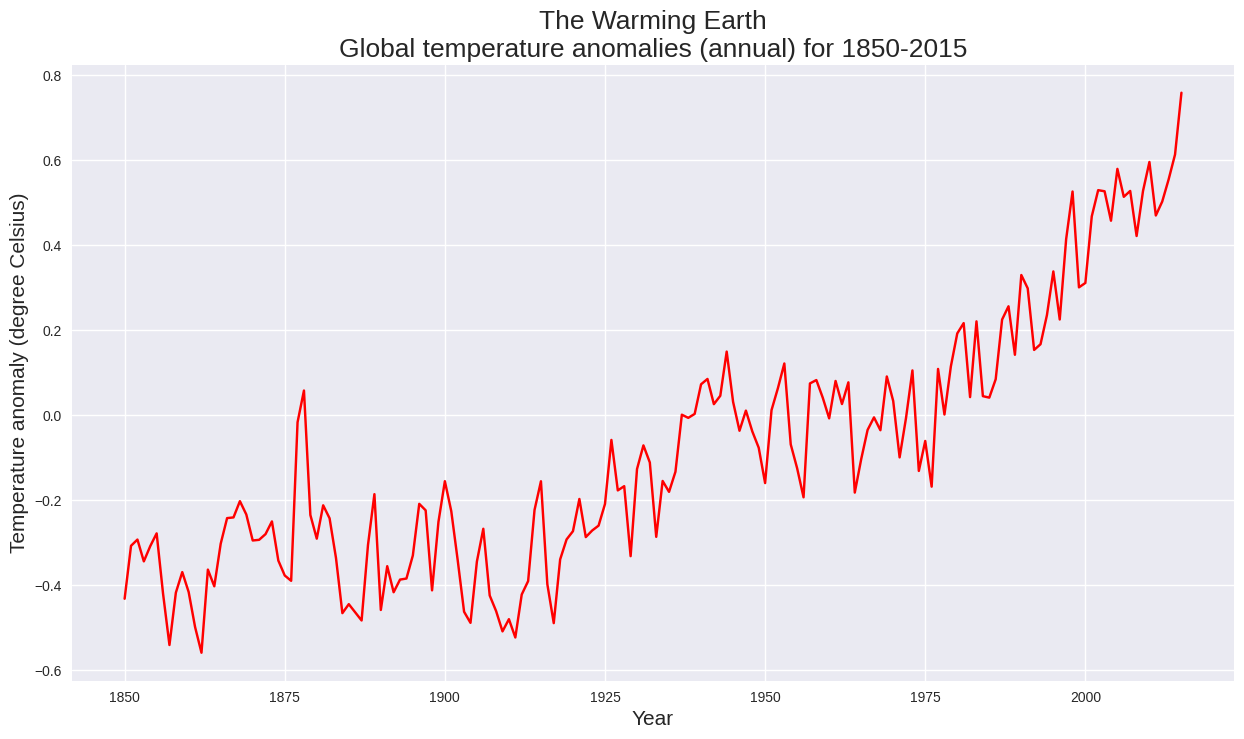

In [8]:
# Plot the temperature anomaly
plt.figure(figsize = (15, 8))

plt.plot(global_temp_df['Temperature Anomaly'], 'r')

plt.title('The Warming Earth\nGlobal temperature anomalies (annual) for 1850-2015', fontsize = 19)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Temperature anomaly (degree Celsius)', fontsize = 15)

plt.show()

Plotting the temperature anomaly over the years, clearly indicates the warming of Earth. The warming is more pronounced from about 1920 onwards. In 2015, the Earth is 0.76 degree Celsius warmer than the normal. The result above confirms the scientific consensus that the Earth is warming.

## Natural disasters

Let's explore the natural disaster data and analyse how the occurrence of various types of natural disasters has changed over the years.

In [9]:
# Load the natural disaster dataset and store it in a dataframe
orig_disaster_data = pd.read_csv('../input/natural-disaster-data/number-of-natural-disaster-events.csv')
nat_disaster_df = orig_disaster_data.copy()

nat_disaster_df.head()

,Entity,Code,Year,Number of reported natural disasters (reported disasters)
0,All natural disasters,NaN,1900,5
1,All natural disasters,NaN,1901,2
2,All natural disasters,NaN,1902,9
3,All natural disasters,NaN,1903,8
4,All natural disasters,NaN,1904,2


In [10]:
# Remove the 'Code' column
nat_disaster_df.drop(['Code'], axis = 1, inplace = True)

# Check the different types of 'Entity' values
nat_disaster_df['Entity'].unique()

array(['All natural disasters', 'Drought', 'Earthquake',
       'Extreme temperature', 'Extreme weather', 'Flood', 'Impact',
       'Landslide', 'Mass movement (dry)', 'Volcanic activity',
       'Wildfire'], dtype=object)

The 'Entity' column contains 10 types of natural disaster entries and their summation, 'All natural disasters'. For further analysis it is suitable to rearrange the data according to the disaster categories.

In [11]:
# Pivot the dataframe
nat_disaster_df = nat_disaster_df.pivot(index = 'Year', columns = 'Entity', values = 'Number of reported natural disasters (reported disasters)')
nat_disaster_df.head()

Entity,All natural disasters,Drought,Earthquake,Extreme temperature,Extreme weather,Flood,Impact,Landslide,Mass movement (dry),Volcanic activity,Wildfire
Year,,,,,,,,,,,
1900,5.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN
1901,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,9.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN
1903,8.0,1.0,1.0,NaN,2.0,2.0,NaN,NaN,1.0,1.0,NaN
1904,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


Global warming doesn't affect the probability of impact by asteroids, meteroites, etc. on Earth. So, the 'Impact' entity can be removed from the dataframe.<br><br>There are several 'NaN' values which could mean missing values or unreported disaster occurrences. For our analysis, we'll replace them with 0, which means no disaster occurrence and it would also benefit plotting the data.

In [12]:
# Remove the 'Impact' column
nat_disaster_df.drop(['Impact'], axis = 1, inplace = True)

# Handle missing values and rename columns
nat_disaster_df.fillna(value = 0, inplace = True)
nat_disaster_df = nat_disaster_df.add_suffix(' (Occurrence)')

nat_disaster_df.head()

Entity,All natural disasters (Occurrence),Drought (Occurrence),Earthquake (Occurrence),Extreme temperature (Occurrence),Extreme weather (Occurrence),Flood (Occurrence),Landslide (Occurrence),Mass movement (dry) (Occurrence),Volcanic activity (Occurrence),Wildfire (Occurrence)
Year,,,,,,,,,,
1900,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1901,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0
1903,8.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0
1904,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


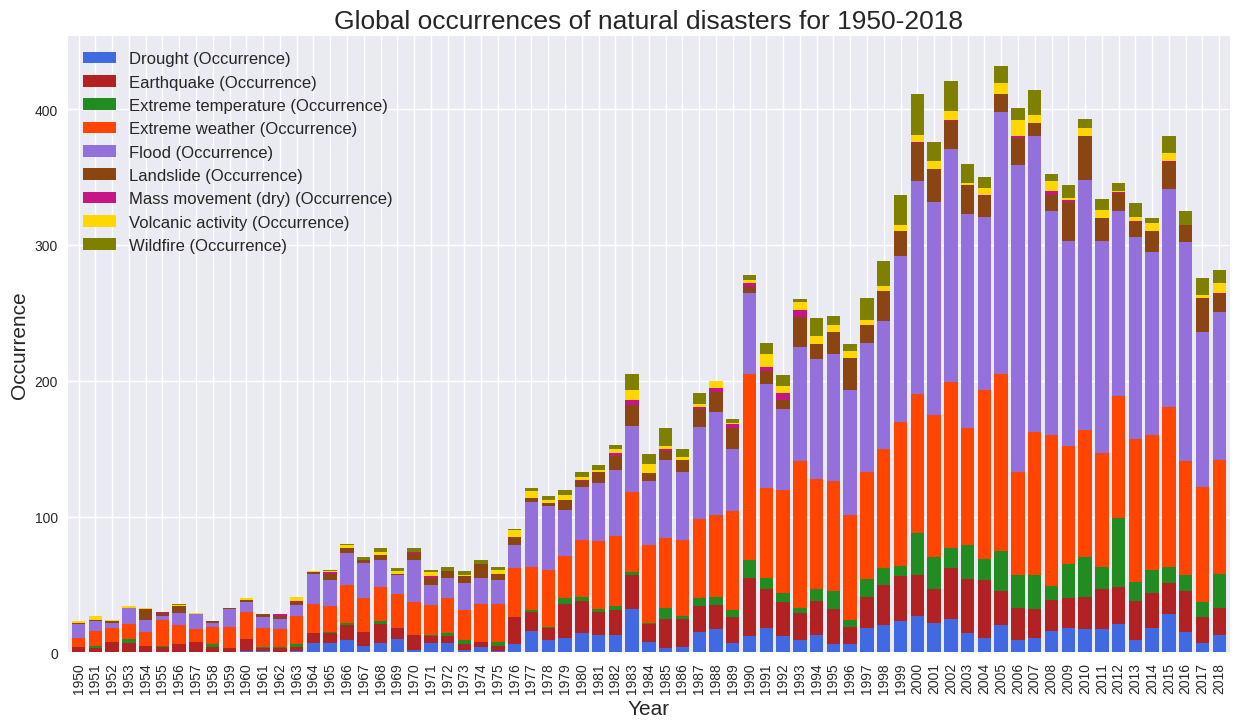

In [13]:
# Plot the types of natural disasters occurrences for 1950-2018
colors = ['#4169e1', '#b22222', '#228b22', '#ff4500', '#9370db', '#8b4513', '#c71585', '#ffd700', 'olive']

nat_disaster_df.drop(['All natural disasters (Occurrence)'], axis = 1).loc[1950:].plot.bar(width = 0.8, stacked = True, color = colors, figsize = (15, 8))

plt.title('Global occurrences of natural disasters for 1950-2018', fontsize = 19)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Occurrence', fontsize = 15)
plt.legend(loc = 2, prop = {'size': 12})

plt.show()

The bar plot above with individual stacks for each disaster category shows that the occurrence of floods has significantly increased over the years relative to other disasters. The next highest increase in occurrence is that of extreme weather followed by earthquakes. The plot also shows that there has been a steady increase in the number of total natural disasters globally. This is more evident from the plot below.

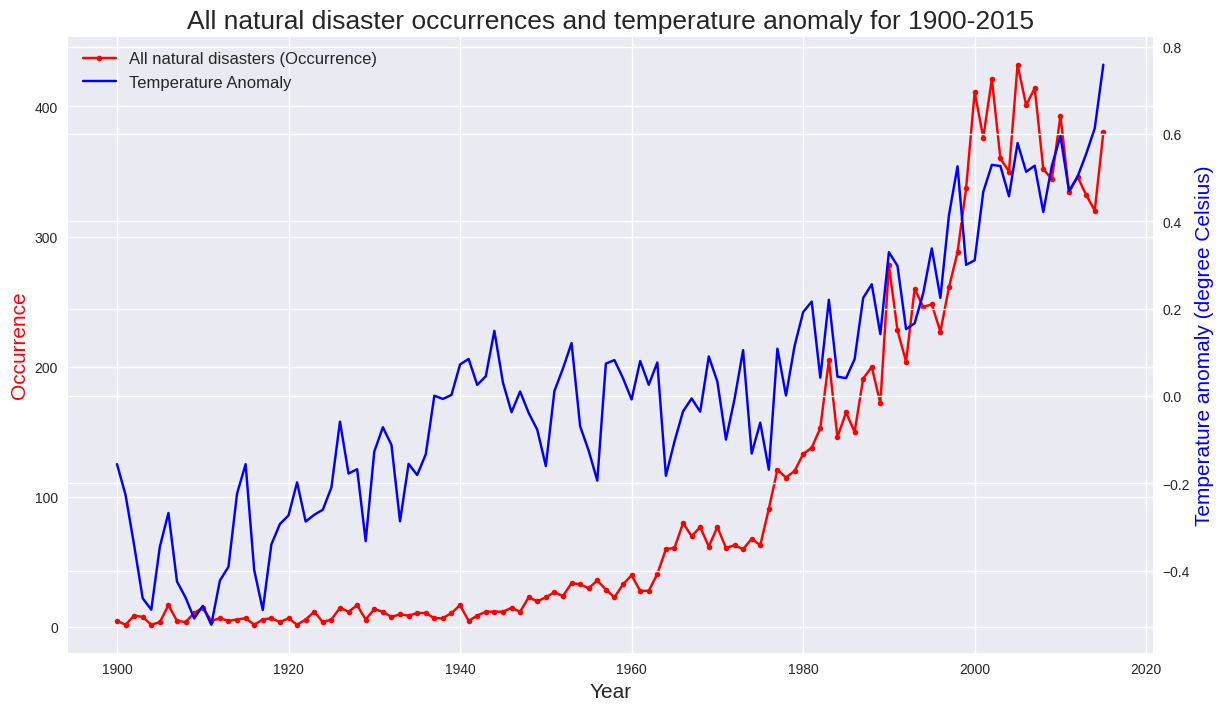

In [18]:
# Plot all natural disasters occurrences and temperature anomaly for comparison
fig, ax = plt.subplots(figsize = (14, 8))
ax2 = ax.twinx()

line1 = ax.plot(nat_disaster_df.loc[:2015, 'All natural disasters (Occurrence)'], '-ro', markersize = 4, label = 'All natural disasters (Occurrence)')
line2 = ax2.plot(global_temp_df.loc[1900:, 'Temperature Anomaly'], 'b-', label = 'Temperature Anomaly')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.title('All natural disaster occurrences and temperature anomaly for 1900-2015', fontsize = 19)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Occurrence', fontsize = 15, color = 'r')
ax2.set_ylabel('Temperature anomaly (degree Celsius)', fontsize = 15, color = 'b')
ax.legend(lines, labels, loc = 0, prop = {'size': 12})

plt.show()

The above plot indicates a positive correlation between temperature anomaly and the occurrence of natural disasters. Especially after around 1940 when it starts becoming warmer than the normal, natural disasters also start rising globally.<br><br>Let's also investigate the economic damage caused by natural disasters.

In [19]:
# Load the economic damage dataset and store it in a dataframe
orig_econ_data = pd.read_csv('../input/natural-disaster-data/economic-damage-from-natural-disasters.csv')
econ_dmg_df = orig_econ_data.copy()

econ_dmg_df.head()

,Entity,Code,Year,Total economic damage from natural disasters (US$)
0,All natural disasters,NaN,1900,30000000
1,All natural disasters,NaN,1901,0
2,All natural disasters,NaN,1902,0
3,All natural disasters,NaN,1903,480000000
4,All natural disasters,NaN,1904,0


In [21]:
# Remove the 'Code' column
econ_dmg_df.drop(['Code'], axis = 1, inplace = True)

# Pivot the dataframe
econ_dmg_df = econ_dmg_df.pivot(index = 'Year', columns = 'Entity', values = 'Total economic damage from natural disasters (US$)')
econ_dmg_df.head()

Entity,All natural disasters,Drought,Earthquake,Extreme temperature,Extreme weather,Flood,Impact,Landslide,Mass movement (dry),Volcanic activity,Wildfire
Year,,,,,,,,,,,
1900,30000000.0,NaN,NaN,NaN,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN
1901,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,480000000.0,NaN,NaN,NaN,NaN,480000000.0,NaN,NaN,NaN,NaN,NaN
1904,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove the irrelevant columns, rename the other columns and handle the missing values.

In [22]:
econ_dmg_df.drop(['Impact'], axis = 1, inplace = True)

econ_dmg_df.fillna(value = 0, inplace = True)
econ_dmg_df = econ_dmg_df.add_suffix(' (Economic Damage)')

econ_dmg_df.head()

Entity,All natural disasters (Economic Damage),Drought (Economic Damage),Earthquake (Economic Damage),Extreme temperature (Economic Damage),Extreme weather (Economic Damage),Flood (Economic Damage),Landslide (Economic Damage),Mass movement (dry) (Economic Damage),Volcanic activity (Economic Damage),Wildfire (Economic Damage)
Year,,,,,,,,,,
1900,30000000.0,0.0,0.0,0.0,30000000.0,0.0,0.0,0.0,0.0,0.0
1901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,480000000.0,0.0,0.0,0.0,0.0,480000000.0,0.0,0.0,0.0,0.0
1904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


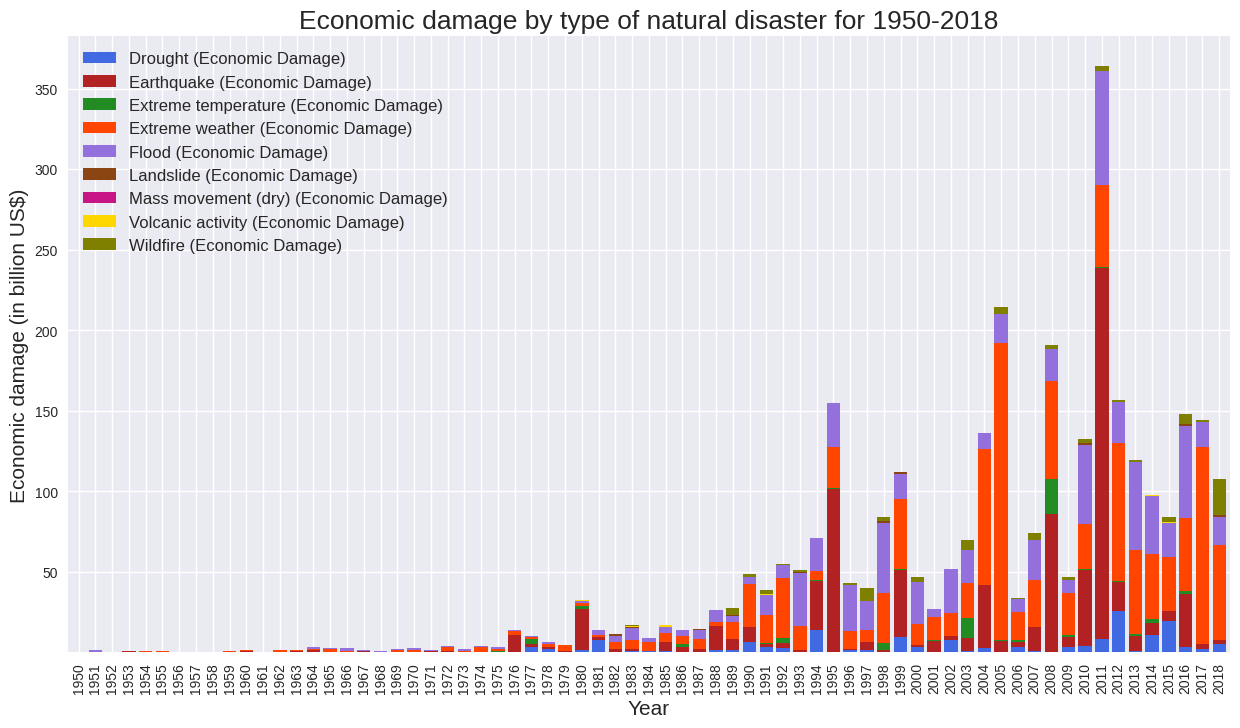

In [23]:
# Plot the economic damage categorised by the type of natural disasters for 1950-2018
((econ_dmg_df.drop(['All natural disasters (Economic Damage)'], axis = 1).loc[1950:]) / 1e9).plot.bar(width = 0.8, stacked = True, color = colors, figsize = (15, 8))

plt.title('Economic damage by type of natural disaster for 1950-2018', fontsize = 19)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Economic damage (in billion US$)', fontsize = 15)
plt.legend(loc = 2, prop = {'size': 12})

plt.show()

Economic damage is highly variable as it depends on several factors such as the disaster type, disaster location, severity of the disaster, disaster management efforts, etc.<br><br>However, one key trend that stands out from the plot is that the total economic damage from all the disasters is generally increasing over the years. The main reason is the increase in disaster occurrences (correlated with global temperature rise), although all disasters don't contribute equally to the economic damage. Another reason for higher economic damage could be the overall increase in economic growth which leads to more infrastructure, land use, etc.<br><br>Combine the three main dataframes (global_temp_df, nat_disaster_df and econ_dmg_df) and create a correlation table to measure the correlation between each entity.

In [24]:
combined_df = global_temp_df.join([nat_disaster_df, econ_dmg_df], how = 'inner')
combined_df.head()

,Temperature Anomaly,All natural disasters (Occurrence),Drought (Occurrence),Earthquake (Occurrence),Extreme temperature (Occurrence),Extreme weather (Occurrence),Flood (Occurrence),Landslide (Occurrence),Mass movement (dry) (Occurrence),Volcanic activity (Occurrence),...,All natural disasters (Economic Damage),Drought (Economic Damage),Earthquake (Economic Damage),Extreme temperature (Economic Damage),Extreme weather (Economic Damage),Flood (Economic Damage),Landslide (Economic Damage),Mass movement (dry) (Economic Damage),Volcanic activity (Economic Damage),Wildfire (Economic Damage)
Year,,,,,,,,,,,,,,,,,,,,,
1900,-0.155631,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,30000000.0,0.0,0.0,0.0,30000000.0,0.0,0.0,0.0,0.0,0.0
1901,-0.226214,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,-0.341214,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,-0.462964,8.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,...,480000000.0,0.0,0.0,0.0,0.0,480000000.0,0.0,0.0,0.0,0.0
1904,-0.489131,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
correlation_table = combined_df.corr()
correlation_table.head()

,Temperature Anomaly,All natural disasters (Occurrence),Drought (Occurrence),Earthquake (Occurrence),Extreme temperature (Occurrence),Extreme weather (Occurrence),Flood (Occurrence),Landslide (Occurrence),Mass movement (dry) (Occurrence),Volcanic activity (Occurrence),...,All natural disasters (Economic Damage),Drought (Economic Damage),Earthquake (Economic Damage),Extreme temperature (Economic Damage),Extreme weather (Economic Damage),Flood (Economic Damage),Landslide (Economic Damage),Mass movement (dry) (Economic Damage),Volcanic activity (Economic Damage),Wildfire (Economic Damage)
Temperature Anomaly,1.000000,0.865128,0.750086,0.796451,0.738191,0.848536,0.841740,0.772180,0.257074,0.669120,...,0.647406,0.515849,0.346882,0.294110,0.588786,0.678628,0.353444,0.010518,0.215112,0.557517
All natural disasters (Occurrence),0.865128,1.000000,0.854789,0.903392,0.859863,0.969517,0.978128,0.894296,0.349152,0.788590,...,0.740809,0.550956,0.400397,0.335689,0.686369,0.759470,0.439097,-0.047811,0.203272,0.624099
Drought (Occurrence),0.750086,0.854789,1.000000,0.815286,0.684009,0.829133,0.785536,0.790511,0.398695,0.710884,...,0.578329,0.583563,0.293073,0.255171,0.525367,0.600423,0.518547,-0.068802,0.251909,0.515664
Earthquake (Occurrence),0.796451,0.903392,0.815286,1.000000,0.721105,0.917687,0.824128,0.778272,0.408753,0.708440,...,0.667560,0.509985,0.394882,0.321490,0.588992,0.663298,0.416438,-0.063196,0.263032,0.538465
Extreme temperature (Occurrence),0.738191,0.859863,0.684009,0.721105,1.000000,0.776985,0.870008,0.751340,0.165342,0.556775,...,0.680193,0.596794,0.316083,0.229073,0.704082,0.657396,0.296600,-0.033887,0.097393,0.569856


A value of 1.0 implies perfect positive correlation, -1.0 implies perfect negative correlation and 0 means no correlation between the two entities. Let's see how temperature anomaly compares to everything.

In [26]:
# Correlation with respect to temperature anomaly
combined_df.corr()['Temperature Anomaly']

Temperature Anomaly                        1.000000
All natural disasters (Occurrence)         0.865128
Drought (Occurrence)                       0.750086
Earthquake (Occurrence)                    0.796451
Extreme temperature (Occurrence)           0.738191
Extreme weather (Occurrence)               0.848536
Flood (Occurrence)                         0.841740
Landslide (Occurrence)                     0.772180
Mass movement (dry) (Occurrence)           0.257074
Volcanic activity (Occurrence)             0.669120
Wildfire (Occurrence)                      0.683839
All natural disasters (Economic Damage)    0.647406
Drought (Economic Damage)                  0.515849
Earthquake (Economic Damage)               0.346882
Extreme temperature (Economic Damage)      0.294110
Extreme weather (Economic Damage)          0.588786
Flood (Economic Damage)                    0.678628
Landslide (Economic Damage)                0.353444
Mass movement (dry) (Economic Damage)      0.010518
Volcanic act

A better way to visualise all the information in the correlation table is through a correlation heatmap.

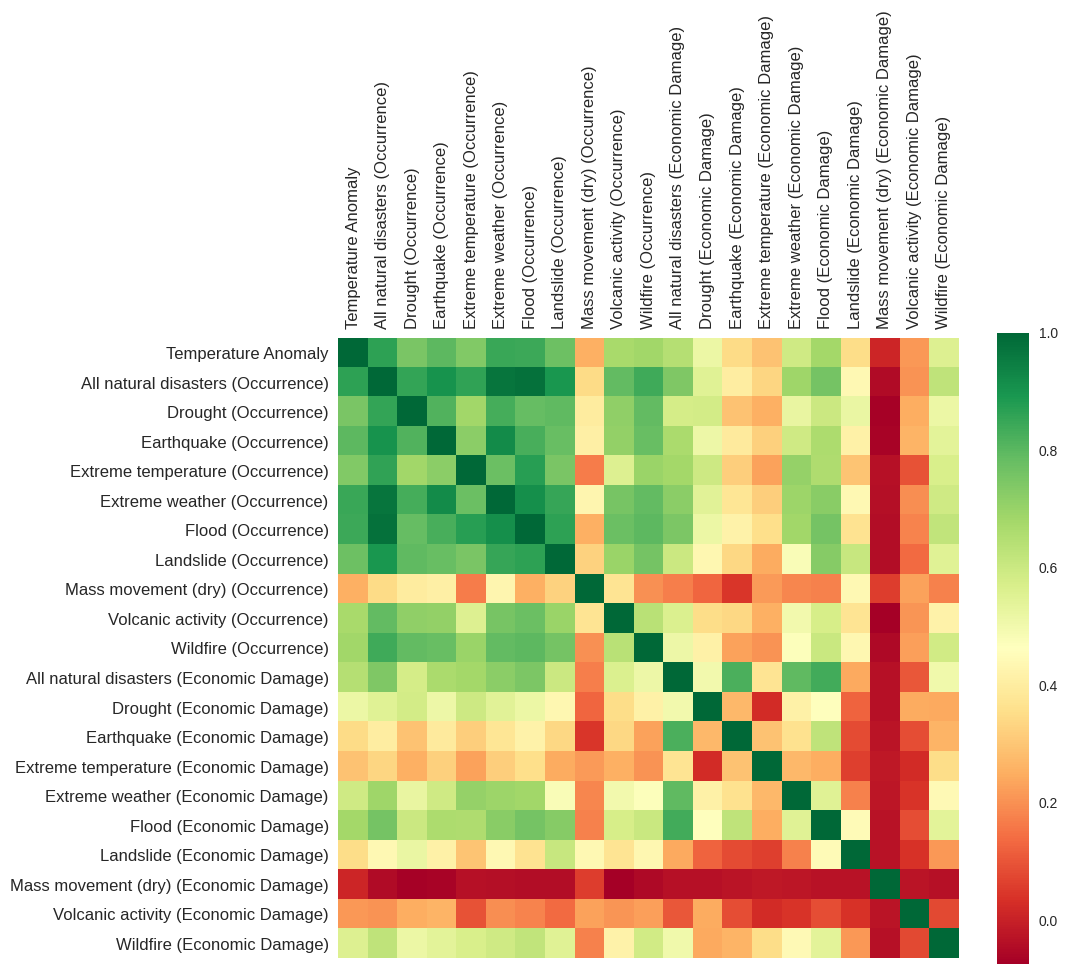

In [27]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize = (10, 10))

labels = [name for name in correlation_table.columns]

cax = ax.matshow(correlation_table, cmap = 'RdYlGn')

cbar = fig.colorbar(cax, shrink = 0.82)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels, fontsize = 12, rotation = 'vertical')
ax.set_yticklabels(labels, fontsize = 12)

ax.grid(False)

plt.show()

The heatmap and the correlation values confirm our analysis from the previous plots that global temperature rise has a strong positive correlation with all types of natural disaster occurrences (except mass movement (dry)) and has a relatively lower correlation with economic damage.